# Free Lunch in Energy Markets

We look at possible arbitrage opportunities in the energy markets by exploiting autocorrelations in the 15 minutes day ahead market.

## Optimal trading
To model the trading we assume a battery with capacity $C$ and we look two vectors of actions $x = (x_0, ..., x_N)$, $y = (y_0, ..., y_N)$ over a period of time  $t=0,..., N$. Here $x_i,y_i\in \{0,1\}$ and $x_i=1$ or $y_i=1$ means charging/discharging a fraction $C/k$ at time $t=i$ for a fixed integer $k>0$, and  a value of $0$ means no action.
For convenience we define the vector of actions $a = x-y$ with values in $\{-1, 0, 1\}$ where $1$ represents charging and $-1$ represents discharging.

Since at any point in time the difference of the charged and discharged amounts needs to be non-negative and less or equal than $C$, we have the following constraint on $x$, $y$:
$$0\leq \sum_{i=0}^j x_i-y_i \leq k, \text{ for all } j\geq 0.$$

For such a pair $x$ and $y$, the revenue generated by these actions depends on a vector of prices $p$.  Since batteries have a finite number of cycles, charging the battery costs $K = \text{purchase price}/\text{number of cycles}$ and we assume in the following that a fractional charge thus amounts to a cost $K/k$. With this assumption, buying the electricity amounts to a total expenditure of $(p\cdot C+K)/k\cdot x$. On the other hand, selling the electricity yields an amount $C/k \cdot \eta\cdot p\cdot y$, where $\eta$ is an efficiency of the battery storage. Thus the (negative) revenue of the actions $a=x-y$ is given by:

$$(p\cdot C +K)/k \cdot x - \eta\cdot C/k\cdot p\cdot y.$$

Now let $TL$ denote the $N\times N$ lower triangular matrix with ones on and below the diagonal.
Then, given $C$, $k$, $K$, $\eta$, $p$, profit maximization can be formulated as the optimization problem:

$$ \min_{x,y}   \biggl(((p\cdot C+K), -\eta\cdot p\cdot C) \cdot (x,y)\cdot 1/k \biggr), \text{ such that } 0\leq (TL, -TL)(x,y)'\leq k \text{ for all } i \text{ and } x,y \in \{0,1\}^{\times N}.$$

This optimization problem is implemented in the function
```python
get_optimal_actions(k_init, p_init, p, C, k,K, eta)
```
below and returns the vector $a= a(k_{init}, p_{init}, p, C, k, K, \eta)$ of optimal actions.
Here, the pair $k_{init}$, $p_{init}$ describes the initial state of the battery. For the following we will assume a discharged battery $k_{init}=0$ and $p_{init}=0$.

Remarks: 
- We did not account for transaction costs explicitely. They could be incorporated into $K$ and $\delta$.


In [1]:
from scipy.optimize import LinearConstraint
import numpy
from scipy.optimize import milp
from scipy import sparse
from numpy.typing import NDArray

def get_optimal_actions(k_init:int, p_init:float, p:NDArray, C: float, k:int, K:float, eta:float):
    
    assert 0<=k_init<=k
    assert 0<=eta<=1
    
    if k_init==0:
        N = len(p)    
        p_mod = numpy.hstack([p*C+K, -eta*p*C])/k
        A = numpy.hstack([numpy.tril([1]*N), -numpy.tril([1]*N)])
        b_l = numpy.ones(N)*0
        b_u = numpy.ones(N)*k
        constraints = LinearConstraint(A, b_l, b_u)
        res = milp(c=p_mod, constraints=constraints, bounds = (0, 1), integrality=1)
        a = res.x[:N]-res.x[N:]
        val = res.fun
    elif k_init>0:
        assert k_init<=k
        N = len(c)
        p_ = numpy.hstack([numpy.array([p_init]), p])
        p_mod = numpy.hstack([p_*C+K, -eta*p_*C])/k
        A = numpy.hstack([numpy.tril([1]*(N+1)), -numpy.tril([1]*(N+1))])
        b_l = numpy.hstack([numpy.array([k_init]), numpy.ones(N)*0])
        b_u = numpy.hstack([numpy.array([k_init]), numpy.ones(N)*k])
        constraints = LinearConstraint(A, b_l, b_u)
        res = milp(c=p_mod, constraints=constraints, bounds = (0, 1), integrality=1)    
        a = res.x[1:N+1]-res.x[N+2:]
        val = res.fun

    return a, val

## Data
The dataset is the 15 minutes day ahead data available from entsoe.eu for the bidding zone DE-LU and in the year 2022.


In [2]:
import pandas
import numpy
import matplotlib.pyplot as plt

def load(fn):
    df = pandas.read_csv(fn)
    print(df.columns)
    assert all(df.columns==["MTU (UTC)", "Day-ahead Price [EUR/MWh]", "Currency", "BZN|DE-LU"])
    df["MTU (UTC)"] = df["MTU (UTC)"].str.replace('"', '')
        
    a = df["MTU (UTC)"].str.split(" - ", expand=True)
    a = a[0]
    df["timestamp"] = pandas.to_datetime(a, dayfirst=True)

    a = df["MTU (UTC)"].str.split(" ", expand=True)
    a = a[0]
    df["day"] = pandas.to_datetime(a, dayfirst=True)

    df["price"] = df["Day-ahead Price [EUR/MWh]"]
        
    df["hourofday"]= df["timestamp"].dt.hour

    df.sort_values("timestamp", inplace=True)    
    
    df = df.drop(columns=["MTU (UTC)", "Day-ahead Price [EUR/MWh]", "Currency", "BZN|DE-LU"])
    return df
    
df_15_22 = load("Day-ahead Prices_202201010000-202301010000.csv")
df_15 = pandas.concat([df_15_22])
df_15["price"] = df_15["price"].astype("float")
df_15 = df_15.groupby(["timestamp"], as_index=False).last()
df_15 = df_15.sort_values("timestamp")
df_15


Index(['MTU (UTC)', 'Day-ahead Price [EUR/MWh]', 'Currency', 'BZN|DE-LU'], dtype='object')


,timestamp,day,price,hourofday
0,2022-01-01 00:00:00,2022-01-01,85.06,0
1,2022-01-01 00:15:00,2022-01-01,36.13,0
2,2022-01-01 00:30:00,2022-01-01,-3.42,0
3,2022-01-01 00:45:00,2022-01-01,-31.94,0
4,2022-01-01 01:00:00,2022-01-01,28.25,1
...,...,...,...,...
35035,2022-12-31 22:45:00,2022-12-31,-29.90,22
35036,2022-12-31 23:00:00,2022-12-31,75.01,23
35037,2022-12-31 23:15:00,2022-12-31,-29.95,23
35038,2022-12-31 23:30:00,2022-12-31,-29.98,23


In [3]:
#df_15 = df_15.head(4*24*30*3).copy()
#df_15

Looking at price increments we find a strong negative autocorrelation in the range 15 to 45 minutes.
Moreover, tails are non-gaussian.

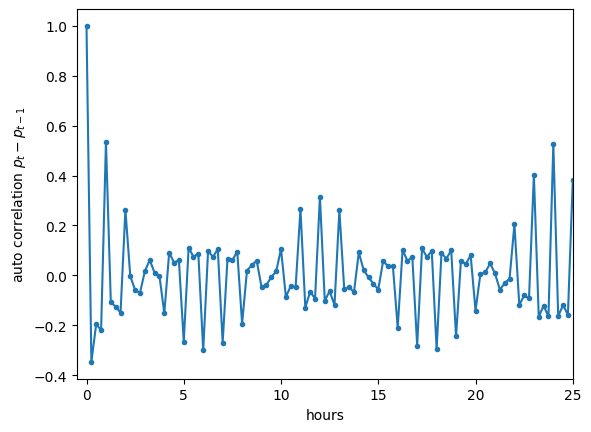

In [4]:
%matplotlib inline

from statsmodels.tsa.stattools import acf, pacf
df_15["dprice15"] = df_15["price"]-df_15["price"].shift(1)

acf_15, cacf_15  = acf(df_15["dprice15"].fillna(0), nlags=24*4*2, alpha=.05)
plt.plot([x/4 for x in range(0, 24*4*2+1)], acf_15, marker=".", color="tab:blue")
plt.xlim(0, 25)
plt.xlabel("hours")
plt.ylabel("auto correlation $p_t-p_{t-1}$")
plt.xlim(-.5, 25)
plt.show()

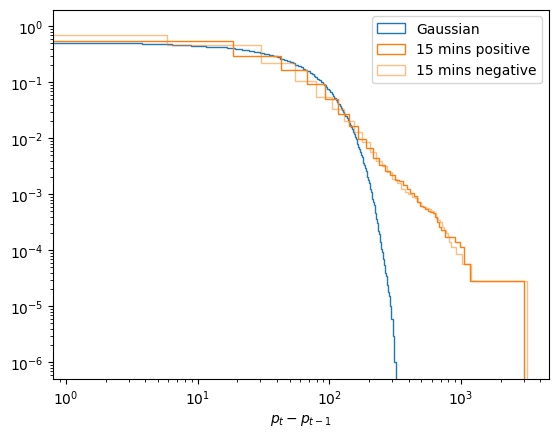

In [5]:
%matplotlib inline

mean = df_15["dprice15"].mean()
std = df_15["dprice15"].std()

normal_s = numpy.random.normal(mean, std, 1000000)

plt.hist(normal_s, cumulative=-1, density=True, bins=250, alpha=1, label="Gaussian", color="tab:blue", histtype="step")
plt.hist(df_15["dprice15"], cumulative=-1, density=True, bins=250, alpha=1, label="15 mins positive", color="tab:orange", histtype="step")
plt.hist(-df_15["dprice15"], cumulative=-1, density=True, bins=250, alpha=.5, label="15 mins negative", color="tab:orange", histtype="step")

plt.xlabel("$p_t-p_{t-1}$")
plt.legend()
plt.yscale("log")
plt.xscale("log")

## Price Forecasting
In reality we don't know future prices.
For clarity we add now an additional parameter $t$ to the variables considered before, which indicates a fixed day.
If we are in a situation where $p(t)=(p_0, ..., p_{23})$ is unknown, e.g. the hourly prices of the next day, we have to replace $p(t)$ by an estimate $\hat{p}(t)$. Given such an estimate we can trade again according to $a(t) = a(k_{init}, p_{init}, f(p(s), s<t), C, k,K, \eta)$.

In the following we look at a simple auto regression model $\hat{p}(t) = \text{AutoReg}(lags,trend,seasonal,period)(p(s), t-\delta<s<t)$ and 
and evaluate the daily return for various values $K$ and $eta$.

Remarks:
- One could potentially improve on this by optimizing over the set of hyperparameters and /or different base models.
- Another source for optimization would be to forecast more frequently.


## Battery assumptions

To understand if the opportunities at the short scales (below $1h$) can be exploited we apply the model (AutoReg with certain parameters) for the $15m$ time series.

The key question is whether trading on these short time scales is beneficial given that costs are actually non-zero.
To make the case, assuming values $C=1$, $K=100=4000000/4000$, $\eta=.92$ seems to be not unrealistic:
https://energetechsolar.com/1mwh-500v-800v-battery-energy-storage-system
Since we are trading on a 15 minutes scale, we have $k=4$.


## Result

We show now that with these assumptions we can easily make positive revenue.

In [6]:
from statsmodels.tsa.api import AutoReg

hyp_15  = {"lags": 4*12, "trend": "c", "seasonal": True, "period": 24*4}
delta_15 = "10d"

C = 1
k = 4
eta = .92
K = 100

In [7]:
unique_days = sorted(df_15["day"].unique())

In [8]:
df_15["a_ar"] = numpy.nan
df_15["a_pi"] = numpy.nan

for i_d, day in enumerate(unique_days[10:]):
    print(day)
    m_15 = df_15["day"]==day
    p_15 = df_15["price"][m_15]

    m_ref_15 = df_15["day"]<day
    m_ref_15 = m_ref_15&(df_15["day"]>=day-pandas.Timedelta(delta_15))
    p_ref_15 = df_15["price"][m_ref_15].values

    model = AutoReg(p_ref_15,**hyp_15)
    model_fit = model.fit()
    phat_15 = model_fit.predict(min(p_15.index), max(p_15.index), dynamic=False)

    a, val = get_optimal_actions(0, 0, phat_15, C, k, K, eta)
    a = pandas.Series(a, m_15[m_15].index)
    df_15.loc[m_15, f"a_ar"] = a

    a, val = get_optimal_actions(0, 0, p_15, C, k, K, eta)
    a = pandas.Series(a, m_15[m_15].index)
    df_15.loc[m_15, f"a_pi"] = a


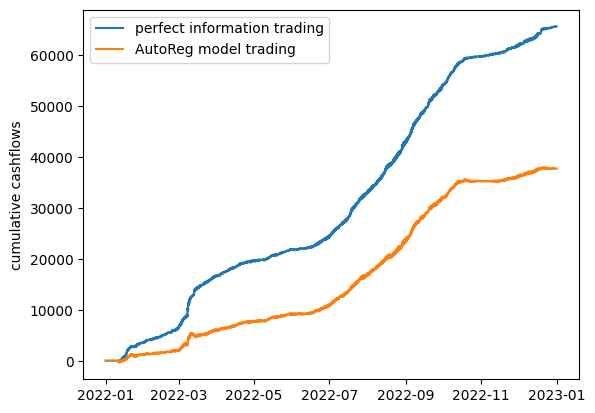

In [9]:
df_15["cashflow_pi"] = -(df_15["a_pi"]==1).astype("float")*(K+df_15["price"]*C)/k + (df_15["a_pi"]==-1).astype("float")*(df_15["price"]*C/k*eta)
df_15["cashflow_ar"] = -(df_15["a_ar"]==1).astype("float")*(K+df_15["price"]*C)/k + (df_15["a_ar"]==-1).astype("float")*(df_15["price"]*C/k*eta)

%matplotlib inline

plt.plot(df_15["timestamp"], df_15["cashflow_pi"].cumsum(), label="perfect information trading")
plt.plot(df_15["timestamp"], df_15["cashflow_ar"].cumsum(), label="AutoReg model trading")
plt.ylabel("cumulative cashflows")
plt.legend()

Revenue and ROI given perfect information:

In [10]:
REVENUE_PI = df_15["cashflow_pi"].sum()
ROI_PI = REVENUE_PI/((df_15["a_pi"]==1).sum()*1/k*K)
REVENUE_PI, ROI_PI

(65609.74540000001, 1.0093806984615388)

Revenue and ROI for auto regressive trading model:

In [11]:
REVENUE_AR = df_15["cashflow_ar"].sum()
ROI_AR = REVENUE_AR/((df_15["a_ar"]==1).sum()*1/k*K)
REVENUE_AR, ROI_AR

(37697.289000000004, 0.6293370450751253)